# Interactively segmenting fibers
Use of insegtPy to segment individual fibers in composite materials

In [32]:
# Import the modules needed 
import insegtpy
import insegtpy.models
import skimage.io
import matplotlib.pyplot as plt
import PIL
import numpy as np
import os
import glob
import pickle

%matplotlib notebook

<IPython.core.display.Javascript object>


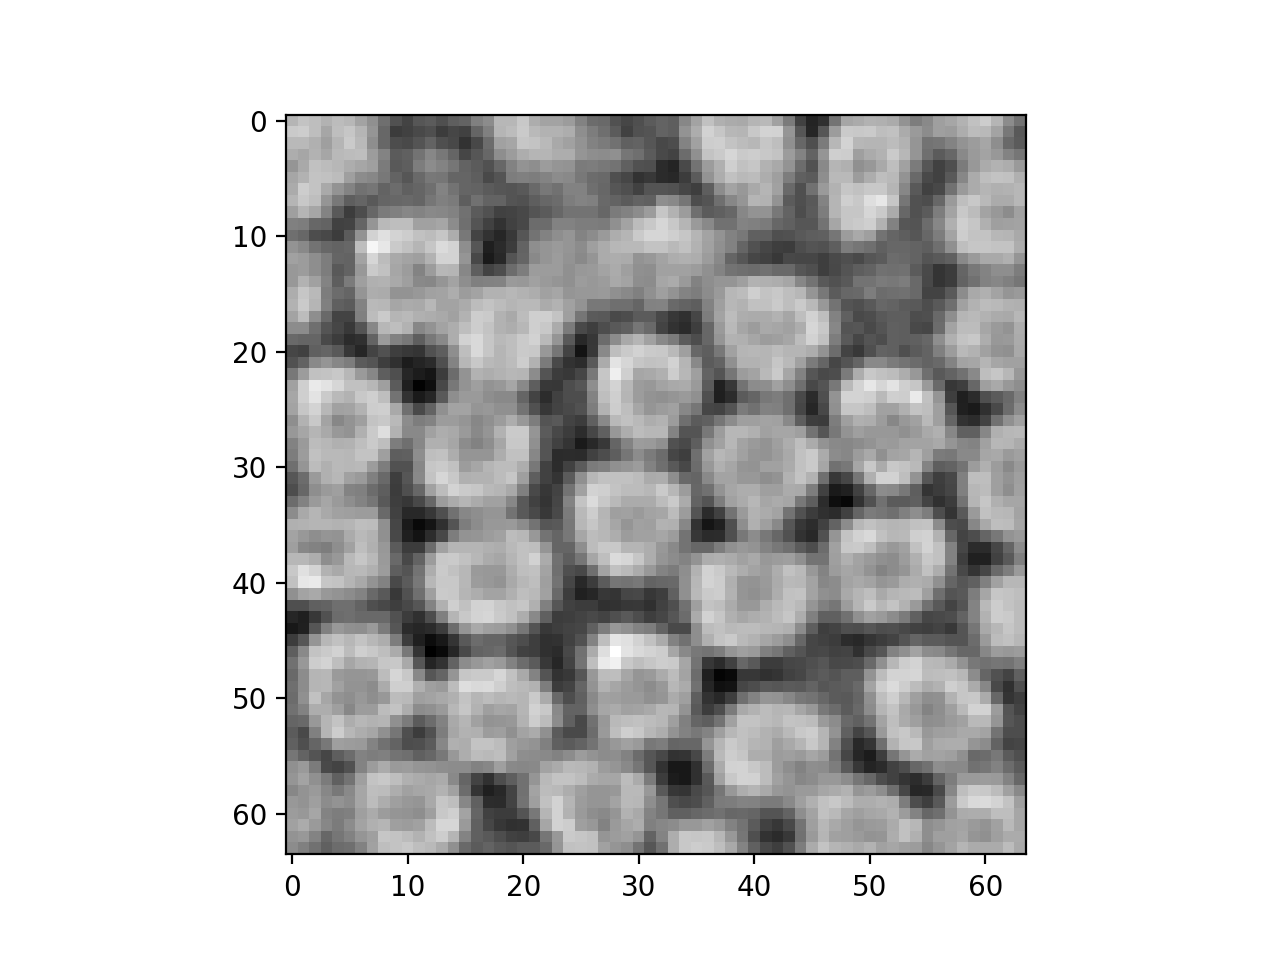

In [33]:
#%% Load image from tiff repository

## Change to directory and image name of choice
dir_in = '/Users/abda/Documents/Center/QIM/data/20220408_fibers/Group_0' 
im_name = 'CFRP_00000.tiff'
##

image_train = skimage.io.imread(os.path.join(dir_in, im_name))

plt.figure()
plt.imshow(image_train, cmap='gray')
plt.show()

In [34]:
#%% Build the model - only possible to build a small model from such a small image

model = insegtpy.models.gauss_features_segmentor(image_train, 
                                   branching_factor = 5, 
                                   number_layers = 4,
                                   number_training_vectors = 4096,
                                   features_sigma = [1,2],
                                   propagation_size = 9, 
                                   scales=[1],
                                   propagation_repetitions=2)

Bulding single-scale GaussFeatSegt model.
Number of images 1
Number of training patches 4096
Number of layers 4 number of elements 780
Adding propagation repetitions.


In [35]:
# Start the annotation GUI
ex = insegtpy.insegt(image_train, model)

Starting InSegt Annotator. For help, hit 'H'.


<IPython.core.display.Javascript object>


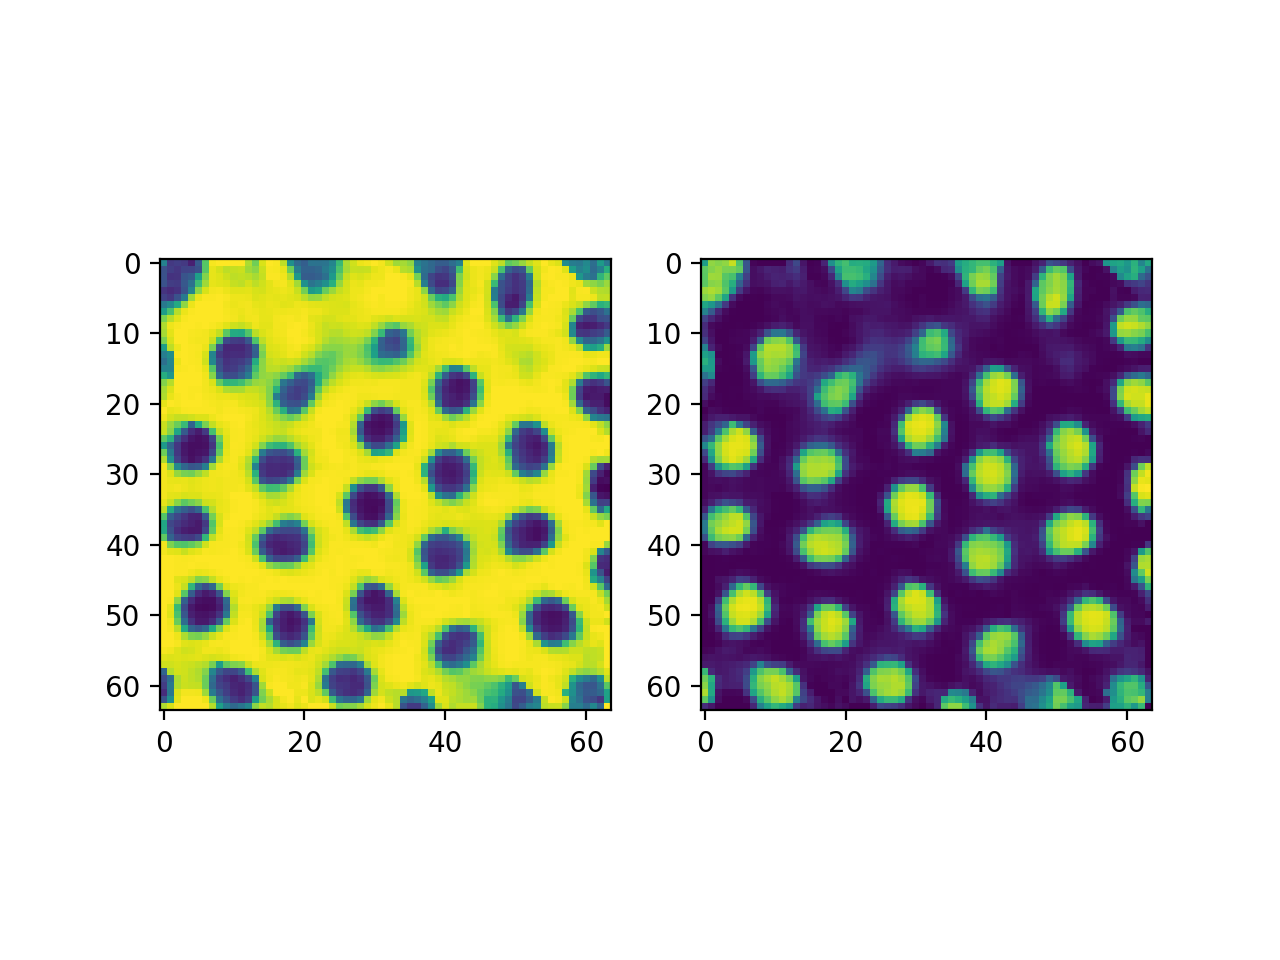

In [36]:
# Show probabilities of segmentation

ncls = ex.probabilities.shape[0]
fig, ax = plt.subplots(1,ncls)
for i in range(ncls):
    ax[i].imshow(ex.probabilities[i])


<IPython.core.display.Javascript object>


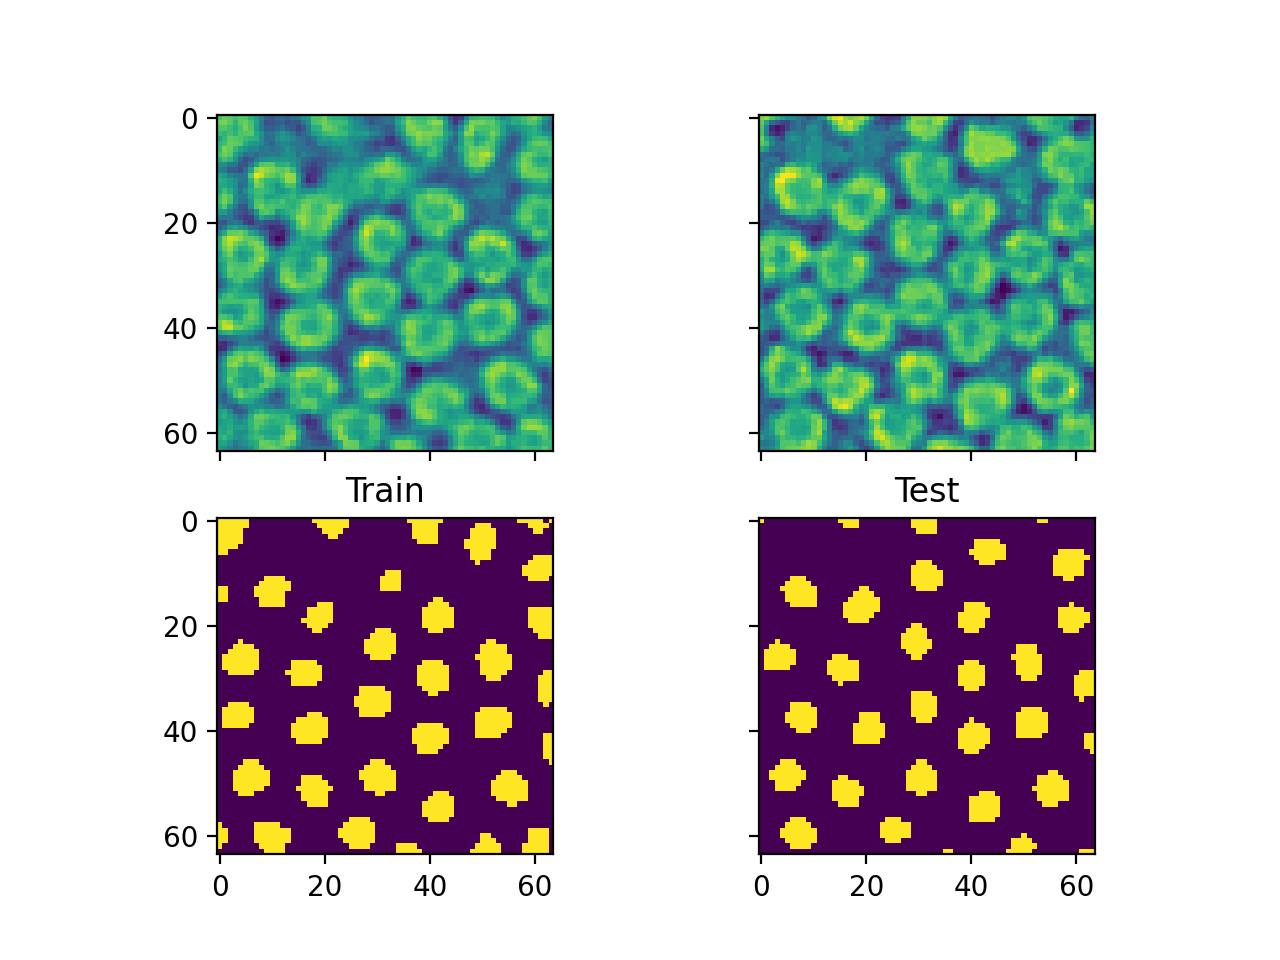

In [37]:
# Compare segmentation of training and test image

prob = ex.probabilities
seg = insegtpy.utils.segment_probabilities(prob)

# Change name if needed
im_name_test = 'CFRP_00050.tiff'

image_test = skimage.io.imread(os.path.join(dir_in, im_name_test))

prob_new = model.segment_new(image_test)
seg_new = insegtpy.utils.segment_probabilities(prob_new)
seg_new[seg_new==0] = 1 # if some pixels are set to zero

fig, ax = plt.subplots(2, 2, sharex = True, sharey = True )
ax[0][0].imshow(image_train)
ax[1][0].imshow(seg)
ax[1][0].set_title('Train')
ax[0][1].imshow(image_test)
ax[1][1].imshow(seg_new)
ax[1][1].set_title('Test')
plt.show()


In [38]:
# Save model to file
dir_out = '/Users/abda/Documents/Center/QIM/data/20220408_fibers/model/'
model_file_name = 'segmentation_two_class_model_1.pkl'
with open(os.path.join(dir_out, model_file_name), 'wb') as f:
    pickle.dump(model, f)


In [39]:
# Segment all files in a repository

dir_in = '/Users/abda/Documents/Center/QIM/data/20220408_fibers/Group_0/' 
im_names = sorted(glob.glob(f'{dir_in}*.tiff'))


import time

im_new = np.array(PIL.Image.open(im_names[0]))
rows, cols = im_new.shape

t = time.time()
V_prob = np.zeros((rows, cols, len(im_names)))
V_seg = np.zeros((rows, cols, len(im_names)))

for i, im_name in enumerate(im_names):
    im_new = np.array(PIL.Image.open(im_name))
    prob = model.segment_new(im_new)
    seg = insegtpy.utils.segment_probabilities(prob)
    seg[seg==0] = 1
    V_prob[i] = prob[1]
    V_seg[i] = seg
print(time.time()-t)

0.31987667083740234


<IPython.core.display.Javascript object>


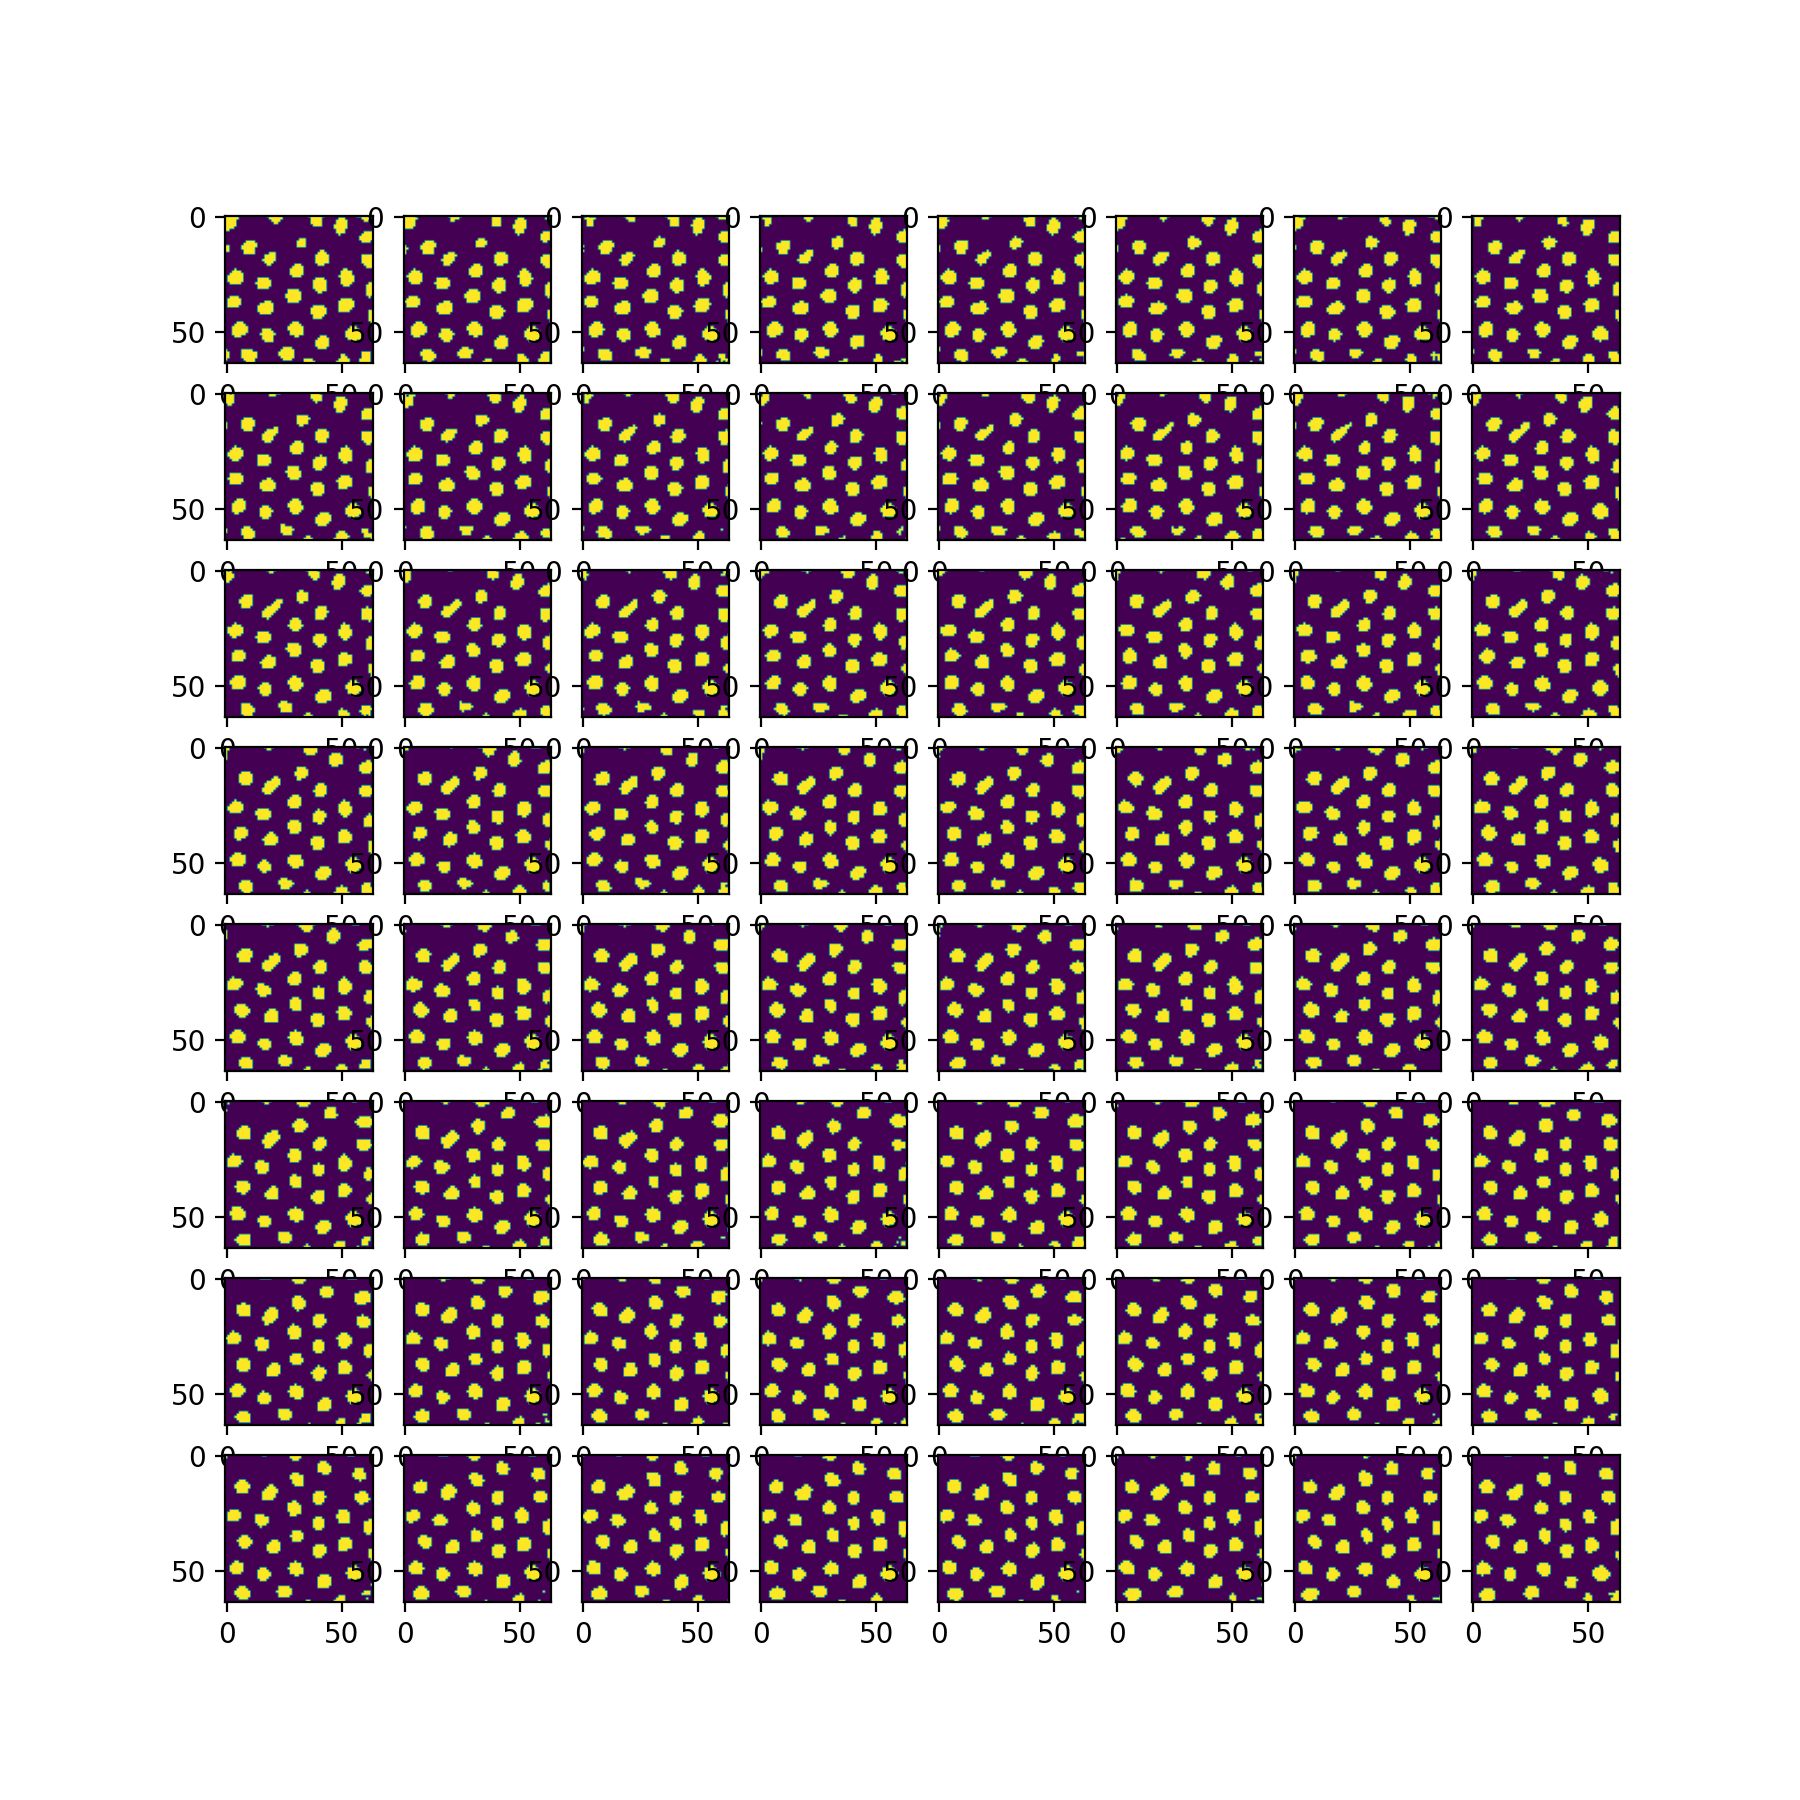

64


In [40]:
# Show the result
fig, ax = plt.subplots(8, 8, figsize=(9,9))
ax = ax.ravel()
print(len(V_prob))
for i in range(len(V_seg)):
    ax[i].imshow(V_seg[i])